### All experiments are logged in Notion [here](https://www.notion.so/Replacement-mode-modeling-257c2f460377498d921e6b167f465945)

In [1]:
from enum import Enum
import random

# Math and graphing.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn imports.
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, r2_score, ConfusionMatrixDisplay

%matplotlib inline

In [2]:
# Global experiment flags and variables.
SEED = 19348
TARGETS = ['p_micro', 'no_trip', 's_car', 'transit', 'car', 's_micro', 'ridehail', 'walk', 'unknown']

DROP_S_MICRO = True

# Set the Numpy seed too.
random.seed(SEED)
np.random.seed(SEED)

In [3]:
class SPLIT_TYPE(Enum):
    INTRA_USER = 0
    INTER_USER = 1
    TARGET = 2
    MODE = 3
    INTER_USER_STATIC = 4
    

class SPLIT(Enum):
    TRAIN = 0
    TEST = 1


def get_train_test_splits(data: pd.DataFrame, how=SPLIT_TYPE, test_ratio=0.2, shuffle=True):
    
    if how == SPLIT_TYPE.INTER_USER:

        X = data.drop(columns=['target'])
        y = data['target'].values
        groups = data.user_id.values
        
        splitter = StratifiedGroupKFold(n_splits=5, shuffle=shuffle, random_state=SEED)
        # splitter = GroupKFold(n_splits=5)
        
        for train_index, test_index in splitter.split(X, y, groups):
            X_tr = data.iloc[train_index, :]
            X_te = data.iloc[test_index, :]
            
            # Iterate only once and break.
            break

        return X_tr, X_te
    
    elif how == SPLIT_TYPE.INTRA_USER:
        
        # There are certain users with only one observation. What do we do with those?
        # As per the mobilitynet modeling pipeline, we randomly assign them to either the
        # training or test set.
        
        value_counts = data.user_id.value_counts()
        single_count_ids = value_counts[value_counts == 1].index
        
        data_filtered = data.loc[~data.user_id.isin(single_count_ids), :].reset_index(drop=True)
        data_single_counts = data.loc[data.user_id.isin(single_count_ids), :].reset_index(drop=True)
        
        X_tr, X_te = train_test_split(
            data_filtered, test_size=test_ratio, shuffle=shuffle, stratify=data_filtered.user_id,
            random_state=SEED
        )
        
        data_single_counts['assigned'] = np.random.choice(['train', 'test'], len(data_single_counts))
        X_tr_merged = pd.concat(
            [X_tr, data_single_counts.loc[data_single_counts.assigned == 'train', :].drop(
                columns=['assigned'], inplace=False
            )],
            ignore_index=True, axis=0
        )
        
        X_te_merged = pd.concat(
            [X_te, data_single_counts.loc[data_single_counts.assigned == 'test', :].drop(
                columns=['assigned'], inplace=False
            )],
            ignore_index=True, axis=0
        )
        
        return X_tr_merged, X_te_merged
    
    elif how == SPLIT_TYPE.TARGET:
        
        X_tr, X_te = train_test_split(
            data, test_size=test_ratio, shuffle=shuffle, stratify=data.target,
            random_state=SEED
        )
        
        return X_tr, X_te
    
    elif how == SPLIT_TYPE.MODE:
        X_tr, X_te = train_test_split(
            data, test_size=test_ratio, shuffle=shuffle, stratify=data.section_mode_argmax,
            random_state=SEED
        )
        
        return X_tr, X_te
    
    elif how == SPLIT_TYPE.INTER_USER_STATIC:
        
        train_ids = ['810be63d084746e3b7da9d943dd88e8c', 'bf774cbe6c3040b0a022278d36a23f19', '8a8332a53a1b4cdd9f3680434e91a6ef', 
                     '5ad862e79a6341f69f28c0096fe884da', '7f89656bd4a94d12ad8e5ad9f0afecaf', 'fbaa338d7cd7457c8cad4d0e60a44d18', 
                     '3b25446778824941a4c70ae5774f4c68', '28cb1dde85514bbabfd42145bdaf7e0a', '3aeb5494088542fdaf798532951aebb0', 
                     '531732fee3c24366a286d76eb534aebc', '950f4287bab5444aa0527cc23fb082b2', '737ef8494f26407b8b2a6b1b1dc631a4', 
                     'e06cf95717f448ecb81c440b1b2fe1ab', '7347df5e0ac94a109790b31ba2e8a02a', 'bd9cffc8dbf1402da479f9f148ec9e60', 
                     '2f3b66a5f98546d4b7691fba57fa640f', 'f289f7001bd94db0b33a7d2e1cd28b19', '19a043d1f2414dbcafcca44ea2bd1f19', 
                     '68788082836e4762b26ad0877643fdcf', '4e8b1b7f026c4384827f157225da13fa', '703a9cee8315441faff7eb63f2bfa93f', 
                     'add706b73839413da13344c355dde0bb', '47b5d57bd4354276bb6d2dcd1438901d', 'e4cfb2a8f600426897569985e234636e', 
                     '0154d71439284c34b865e5a417cd48af', '234f4f2366244fe682dccded2fa7cc4e', '0d0ae3a556414d138c52a6040a203d24', 
                     '44c10f66dec244d6b8644231d4a8fecb', '30e9b141d7894fbfaacecd2fa18929f9', '0eb313ab00e6469da78cc2d2e94660fb', 
                     'fc51d1258e4649ecbfb0e6ecdaeca454', 'a1954793b1454b2f8cf95917d7547169', '6656c04c6cba4c189fed805eaa529741', 
                     '6a0f3653b80a4c949e127d6504debb55', 'dfe5ca1bb0854b67a6ffccad9565d669', '8b1f3ba43de945bea79de6a81716ad04', 
                     'cde34edb8e3a4278a18e0adb062999e5', '6d96909e5ca442ccb5679d9cdf3c8f5b', 'a60a64d82d1c439a901b683b73a74d73', 
                     '60e6a6f6ed2e4e838f2bbed6a427028d', '88041eddad7542ea8c92b30e5c64e198', '1635c003b1f94a399ebebe21640ffced', 
                     '1581993b404a4b9c9ca6b0e0b8212316', 'b1aed24c863949bfbfa3a844ecf60593', '4b89612d7f1f4b368635c2bc48bd7993', 
                     'eb2e2a5211564a9290fcb06032f9b4af', '26767f9f3da54e93b692f8be6acdac43', '8a98e383a2d143e798fc23869694934a', 
                     'b346b83b9f7c4536b809d5f92074fdae', 'd929e7f8b7624d76bdb0ec9ada6cc650', '863e9c6c8ec048c4b7653f73d839c85b', 
                     'f50537eb104e4213908f1862c8160a3e', '4a9db5a9bac046a59403b44b883cc0ba', 'cded005d5fd14c64a5bba3f5c4fe8385', 
                     'c7ce889c796f4e2a8859fa2d7d5068fe', '405b221abe9e43bc86a57ca7fccf2227', '0b3e78fa91d84aa6a3203440143c8c16', 
                     'fbff5e08b7f24a94ab4b2d7371999ef7', 'e35e65107a34496db49fa5a0b41a1e9e', 'd5137ebd4f034dc193d216128bb7fc9a', 
                     '3f7f2e536ba9481e92f8379b796ad1d0', 'dc75e0b776214e1b9888f6abd042fd95', 'b41dd7d7c6d94fe6afe2fd26fa4ac0bd', 
                     'eec6936e1ac347ef9365881845ec74df', '8c7d261fe8284a42a777ffa6f380ba3b', '4baf8c8af7b7445e9067854065e3e612', 
                     'c6e4db31c18b4355b02a7dd97deca70b', 'f0db3b1999c2410ba5933103eca9212f', '487e20ab774742378198f94f5b5b0b43', 
                     'dc1ed4d71e3645d0993885398d5628ca', '8c3c63abb3ec4fc3a61e7bf316ee4efd', '15eb78dd6e104966ba6112589c29dc41', 
                     'c23768ccb817416eaf08be487b2e3643', 'ecd2ae17d5184807abd87a287115c299', '71f21d53b655463784f3a3c63c56707b', 
                     '2931e0a34319495bbb5898201a54feb5', '92bde0d0662f45ac864629f486cffe77', '42b3ee0bc02a481ab1a94644a8cd7a0d', 
                     '15aa4ba144a34b8b8079ed7e049d84df', '509b909390934e988eb120b58ed9bd8c', '14103cda12c94642974129989d39e50d', 
                     '8b0876430c2641bcaea954ea00520e64', 'baa4ff1573ae411183e10aeb17c71c53', '14fe8002bbdc4f97acbd1a00de241bf6', 
                     '1b7d6dfea8464bcab9321018b10ec9c9', '487ad897ba93404a8cbe5de7d1922691', '5182d93d69754d7ba06200cd1ac5980a', 
                     '91f3ca1c278247f79a806e49e9cc236f', 'e66e63b206784a559d977d4cb5f1ec34', '840297ae39484e26bfebe83ee30c5b3e', 
                     'c6807997194c4c528a8fa8c1f6ee1595', '802667b6371f45b29c7abb051244836a', 'b2bbe715b6a14fd19f751cae8adf6b4e', 
                     'feb1d940cd3647d1a101580c2a3b3f8c', '1b9883393ab344a69bc1a0fab192a94c', 'ac604b44fdca482fb753034cb55d1351', 
                     'f446bf3102ff4bd99ea1c98f7d2f7af0', 'c2c5d4b9a607487ea405a99c721079d4', '85ddd3c34c58407392953c47a32f5428', 
                     'd51de709f95045f8bacf473574b96ba5', '6373dfb8cb9b47e88e8f76adcfadde20', '313d003df34b4bd9823b3474fc93f9f9', 
                     '53e78583db87421f8decb529ba859ca4', '8fdc9b926a674a9ea07d91df2c5e06f2', '90480ac60a3d475a88fbdab0a003dd5d', 
                     '7559c3f880f341e898a402eba96a855d', '19a4c2cf718d40588eb96ac25a566353', 'f4427cccaa9442b48b42bedab5ab648e', 
                     'e192b8a00b6c422296851c93785deaf7', '355e25bdfc244c5e85d358e39432bd44', 'a0c3a7b410b24e18995f63369a31d123', 
                     '03a395b4d8614757bb8432b4984559b0', 'a2d48b05d5454d428c0841432c7467b6', '3d981e617b304afab0f21ce8aa6c9786', 
                     '2cd5668ac9054e2eb2c88bb4ed94bc6d', 'd7a732f4a8644bcbb8dedfc8be242fb2', '367eb90b929d4f6e9470d15c700d2e3f', 
                     'e049a7b2a6cb44259f907abbb44c5abc', 'a231added8674bef95092b32bc254ac8', 'e88a8f520dde445484c0a9395e1a0599',
                     'cba570ae38f341faa6257342727377b7', '97953af1b97d4e268c52e1e54dcf421a', 'd200a61757d84b1dab8fbac35ff52c28', 
                     'fc68a5bb0a7b4b6386b3f08a69ead36f', '4a8210aec25e443391efb924cc0e5f23', '903742c353ce42c3ad9ab039fc418816', 
                     '2114e2a75304475fad06ad201948fbad', 'ac917eae407c4deb96625dd0dc2f2ba9', '3dddfb70e7cd40f18a63478654182e9a', 
                     'd3735ba212dd4c768e1675dca7bdcb6f', '7abe572148864412a33979592fa985fb', 'd3dff742d07942ca805c2f72e49e12c5' 
                     ]
        
        X_tr = data.loc[data.user_id.isin(train_ids), :]
        X_te = data.loc[~data.user_id.isin(train_ids), :]
        
        return X_tr, X_te
    
    raise NotImplementedError("Unknown split type")

## Modeling

In [4]:
# Read the data.
# data = pd.read_csv('../data/FULL_preprocessed_data_RM_weather.csv')
# data = pd.read_csv('../data/ReplacedMode_Fix.csv')
data = pd.read_csv('../data/ReplacedMode_Fix_02142024.csv')

/var/folders/4x/l9lw50rn7qvf79m01f21x70mlpd6gh/T/ipykernel_76325/2274972291.py:4: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/ReplacedMode_Fix_02142024.csv')


In [5]:
if DROP_S_MICRO:
    data.drop(
        index=data.loc[data.target == 6, :].index,
        inplace=True
    )
    
    # Shift all values after 6 by -1
    data.loc[data.target > 5, 'target'] -= 1

In [6]:
data.drop_duplicates(inplace=True)

In [7]:
def plot_hist(df, features=None):
    if not features:
        # All features.
        features = df.columns.tolist()
        
    n_features = len(features)
    
    ncols = 6
    nrows = n_features//ncols if n_features%ncols == 0 else (n_features//ncols) + 1
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    for ix, ax in enumerate(axes.flatten()):
        
        if ix > n_features:
            break
        
        df[features[ix]].hist(ax=ax)
        ax.set(title=features[ix])
    
    plt.tight_layout()
    plt.show()

In [8]:
# First, we map the user IDs to ints.

# USERS = list(data.user_id.unique())

# USER_MAP = {
#     u: i+1 for (i, u) in enumerate(USERS)
# }

# data['user_id'] = data['user_id'].apply(lambda x: USER_MAP[x])

# data.rename(
#     columns={'start_local_dt_weekday': 'start:DOW', 'end_local_dt_weekday': 'end:DOW'},
#     inplace=True
# )

# Drop the samples with chosen == no trip or chosen == unknown
# data.drop(index=data.loc[data.chosen.isin([2, 9])].index, inplace=True)

# data.n_working_residents = data.n_working_residents.apply(lambda x: 0 if x < 0 else x)

# Fix some age preprocessing issues.
# data.age = data.age.apply(lambda x: x if x < 100 else 2024-x)

# Collapse 'train' and 'bus' into 'transit'
# data.loc[
#     data.section_mode_argmax.isin(['train', 'bus']), 'section_mode_argmax'
# ] = 'transit'

In [9]:
# display(data.section_mode_argmax.value_counts())

In [10]:
# transit = data.loc[data.section_mode_argmax == 'transit', :].copy()
# transit['section_duration_argmax'] /= 60.

# transit['mph'] = transit['section_distance_argmax']/transit['section_duration_argmax']

# display(transit[['section_duration_argmax', 'section_distance_argmax', 'mph']].describe())

In [11]:
# import plotly.express as px

# sp = data.loc[data.section_mode_argmax.isin(['car', 'transit', 'walking']), :]
# fig = px.line(sp, y='section_distance_argmax', color='section_mode_argmax')
# fig.show()

In [12]:
# Close the figure above.
# plt.close()

In [13]:
def get_duration_estimate(df: pd.DataFrame, dset: SPLIT, model_dict: dict):
    
    X_features = ['section_distance_argmax', 'age']
    
    if 'mph' in df.columns:
        X_features += ['mph']
    
    if dset == SPLIT.TRAIN and model_dict is None:
        model_dict = dict()
    
    if dset == SPLIT.TEST and model_dict is None:
        raise AttributeError("Expected model dict for testing.")
    
    if dset == SPLIT.TRAIN:
        for section_mode in df.section_mode_argmax.unique():
            section_data = df.loc[df.section_mode_argmax == section_mode, :]
            if section_mode not in model_dict:
                model_dict[section_mode] = dict()

                model = LinearRegression(fit_intercept=True)

                X = section_data[
                    X_features
                ]
                Y = section_data[['section_duration_argmax']]

                model.fit(X, Y.values.ravel())

                r2 = r2_score(y_pred=model.predict(X), y_true=Y.values.ravel())
                print(f"Train R2 for {section_mode}: {r2}")

                model_dict[section_mode]['model'] = model
                
    elif dset == SPLIT.TEST:
        for section_mode in df.section_mode_argmax.unique():
            section_data = df.loc[df.section_mode_argmax == section_mode, :]
            X = section_data[
                X_features
            ]
            Y = section_data[['section_duration_argmax']]
            
            y_pred = model_dict[section_mode]['model'].predict(X)
            r2 = r2_score(y_pred=y_pred, y_true=Y.values.ravel())
            print(f"Test R2 for {section_mode}: {r2}")
    
    # Create the new columns for the duration.
    new_columns = ['p_micro','no_trip','s_car','transit','car','s_micro','ridehail','walk','unknown']
    df[new_columns] = 0
    df['temp'] = 0
    
    for section in df.section_mode_argmax.unique():
        X_section = df.loc[df.section_mode_argmax == section, X_features]
        
        # broadcast to all columns.
        df.loc[df.section_mode_argmax == section, 'temp'] = model_dict[section]['model'].predict(X_section)
    
    for c in new_columns:
        df[c] = df['av_' + c] * df['temp']
    
    df.drop(columns=['temp'], inplace=True)
    
    df.rename(columns=dict([(x, 'tt_'+x) for x in new_columns]), inplace=True)
    
    # return model_dict, result_df
    return model_dict, df

In [14]:
# Now, we split the data.
train_data, test_data = get_train_test_splits(data=data, how=SPLIT_TYPE.INTER_USER)

In [15]:
# If split is inter-user, we should verify test size.

n_tr, n_te = len(train_data.user_id.unique()), len(test_data.user_id.unique())
n_ex_tr, n_ex_te = train_data.shape[0], test_data.shape[0]

print(n_tr/(n_tr+n_te))
print(n_ex_tr/(n_ex_tr+n_ex_te))

0.7757575757575758
0.8380486968449932


In [16]:
print(train_data.columns.tolist())

['source', 'end_ts', 'end_fmt_time', 'end_loc', 'raw_trip', 'start_ts', 'start_fmt_time', 'start_loc', 'duration', 'distance', 'start_place', 'end_place', 'cleaned_trip', 'inferred_labels', 'inferred_trip', 'expectation', 'confidence_threshold', 'expected_trip', 'user_input', 'start:year', 'start:month', 'start:day', 'start:hour', 'start_local_dt_minute', 'start_local_dt_second', 'start_local_dt_weekday', 'start_local_dt_timezone', 'end:year', 'end:month', 'end:day', 'end:hour', 'end_local_dt_minute', 'end_local_dt_second', 'end_local_dt_weekday', 'end_local_dt_timezone', '_id', 'user_id', 'metadata_write_ts', 'additions', 'mode_confirm', 'purpose_confirm', 'distance_miles', 'Mode_confirm', 'Trip_purpose', 'original_user_id', 'program', 'opcode', 'Timestamp', 'birth_year', 'primary_job_commute_time', 'income_category', 'n_residence_members', 'n_residents_u18', 'n_residents_with_license', 'n_motor_vehicles', 'available_modes', 'age', 'gender_Man', 'gender_Man;Nonbinary/genderqueer/gende

In [17]:
params, train_data = get_duration_estimate(train_data, SPLIT.TRAIN, None)
print(10 * "-")
_, test_data = get_duration_estimate(test_data, SPLIT.TEST, params)

Train R2 for bicycling: 0.9131217438269534
Train R2 for transit: 0.7868655990732462
Train R2 for car: 0.7673262331496208
Train R2 for no_sensed: 0.6274006368569693
Train R2 for walking: 0.6356687086293809


/var/folders/4x/l9lw50rn7qvf79m01f21x70mlpd6gh/T/ipykernel_76325/1465244600.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_columns] = 0
/var/folders/4x/l9lw50rn7qvf79m01f21x70mlpd6gh/T/ipykernel_76325/1465244600.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_columns] = 0
/var/folders/4x/l9lw50rn7qvf79m01f21x70mlpd6gh/T/ipykernel_76325/1465244600.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

----------
Test R2 for bicycling: 0.9035643287707561
Test R2 for transit: 0.41808445188600185
Test R2 for car: 0.729524725154663
Test R2 for no_sensed: 0.708585489321987
Test R2 for walking: 0.6801138679986298


In [18]:
train_data.shape, test_data.shape

((58650, 139), (11334, 139))

In [19]:
# Some helper functions that will help ease redundancy in the code.

def drop_columns(df: pd.DataFrame):
    to_drop = [
        'source', 'end_ts', 'end_fmt_time', 'end_loc', 'raw_trip', 'start_ts', 
        'start_fmt_time', 'start_loc', 'duration', 'distance', 'start_place', 
        'end_place', 'cleaned_trip', 'inferred_labels', 'inferred_trip', 'expectation',
        'confidence_threshold', 'expected_trip', 'user_input', 'start:year', 'start:month', 
        'start:day', 'start_local_dt_minute', 'start_local_dt_second', 
        'start_local_dt_weekday', 'start_local_dt_timezone', 'end:year', 'end:month', 'end:day', 
        'end_local_dt_minute', 'end_local_dt_second', 'end_local_dt_weekday', 
        'end_local_dt_timezone', '_id', 'user_id', 'metadata_write_ts', 'additions', 
        'mode_confirm', 'purpose_confirm', 'Mode_confirm', 'Trip_purpose', 
        'original_user_id', 'program', 'opcode', 'Timestamp', 'birth_year', 
        'available_modes', 'section_coordinates_argmax', 'section_mode_argmax'
    ]
    
    # Drop section_mode_argmax and available_modes.
    return df.drop(
        columns=to_drop, 
        inplace=False
    )


def scale_values(df: pd.DataFrame, split: SPLIT, scalers=None):
    # Scale costs using StandardScaler.
    costs = df[[c for c in df.columns if 'cost_' in c]].copy()
    times = df[[c for c in df.columns if 'tt_' in c or 'duration' in c]].copy()
    distances = df[[c for c in df.columns if 'distance' in c]]
    
    print(
        "Cost columns to be scaled: ", costs.columns,"\nTime columns to be scaled: ", times.columns, \
        "\nDistance columns to be scaled: ", distances.columns
    )
    
    if split == SPLIT.TRAIN and scalers is None:
        cost_scaler = StandardScaler()
        tt_scaler = StandardScaler()
        dist_scaler = StandardScaler()
        
        cost_scaled = pd.DataFrame(
            cost_scaler.fit_transform(costs), 
            columns=costs.columns, 
            index=costs.index
        )
        
        tt_scaled = pd.DataFrame(
            tt_scaler.fit_transform(times),
            columns=times.columns,
            index=times.index
        )
        
        dist_scaled = pd.DataFrame(
            dist_scaler.fit_transform(distances),
            columns=distances.columns,
            index=distances.index
        )
    
    elif split == SPLIT.TEST and scalers is not None:
        
        cost_scaler, tt_scaler, dist_scaler = scalers
        
        cost_scaled = pd.DataFrame(
            cost_scaler.transform(costs), 
            columns=costs.columns, 
            index=costs.index
        )
        
        tt_scaled = pd.DataFrame(
            tt_scaler.transform(times), 
            columns=times.columns, 
            index=times.index
        )
        
        dist_scaled = pd.DataFrame(
            dist_scaler.transform(distances),
            columns=distances.columns,
            index=distances.index
        )
        
    else:
        raise NotImplementedError("Unknown split")
    
    # Drop the original columns.
    df.drop(
        columns=costs.columns.tolist() + times.columns.tolist() + distances.columns.tolist(), 
        inplace=True
    )
    
    df = df.merge(right=cost_scaled, left_index=True, right_index=True)
    df = df.merge(right=tt_scaled, left_index=True, right_index=True)
    df = df.merge(right=dist_scaled, left_index=True, right_index=True)
    
    return df, (cost_scaler, tt_scaler, dist_scaler)

In [20]:
# First, drop columns.

train_data = drop_columns(train_data)

# Scale cost.
# train_data, scalers = scale_values(train_data, SPLIT.TRAIN, None)

In [21]:
test_data = drop_columns(test_data)

# Scale cost.
# test_data, _ = scale_values(test_data, SPLIT.TEST, scalers)

In [22]:
print(train_data.columns)

Index(['start:hour', 'end:hour', 'distance_miles', 'primary_job_commute_time',
       'income_category', 'n_residence_members', 'n_residents_u18',
       'n_residents_with_license', 'n_motor_vehicles', 'age', 'gender_Man',
       'gender_Man;Nonbinary/genderqueer/genderfluid',
       'gender_Nonbinary/genderqueer/genderfluid', 'gender_Prefer not to say',
       'gender_Woman', 'gender_Woman;Nonbinary/genderqueer/genderfluid',
       'has_drivers_license_No', 'has_drivers_license_Prefer not to say',
       'has_drivers_license_Yes', 'has_multiple_jobs_No',
       'has_multiple_jobs_Prefer not to say', 'has_multiple_jobs_Yes',
       'highest_education_Bachelor's degree',
       'highest_education_Graduate degree or professional degree',
       'highest_education_High school graduate or GED',
       'highest_education_Less than a high school graduate',
       'highest_education_Prefer not to say',
       'highest_education_Some college or associates degree',
       'primary_job_type_Full

In [23]:
len(train_data.target.unique())

8

In [24]:
# train_data.to_csv('../data/train.csv', index=False)
# test_data.to_csv('../data/test.csv', index=False)

In [25]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from pprint import pprint
from sklearn.inspection import permutation_importance
from time import perf_counter

## Random Forest classifier

In [35]:
CV = False
SAVE_MODEL = True

In [36]:
from sklearn.ensemble import RandomForestClassifier

# exp question - compute sample weights using user_id.

rf_train = train_data.drop(columns=['target', 
                                    'start_lat', 'start_lng', 'end_lat', 'end_lng'
                                   ])
rf_test = test_data.drop(columns=['target', 
                                  'start_lat', 'start_lng', 'end_lat', 'end_lng'
                                 ])

if CV:

    model = RandomForestClassifier(random_state=SEED)

    # We want to build bootstrapped trees that would not always use all the features.

    param_set2 = {
        'n_estimators': [150, 200, 250, 300],
        'min_samples_split': [2, 3, 4],
        'min_samples_leaf': [1, 2, 3],
        'class_weight': ['balanced_subsample'],
        'max_features': [None, 'sqrt'],
        'bootstrap': [True]
    }

    cv_set2 = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

    clf_set2 = GridSearchCV(model, param_set2, cv=cv_set2, n_jobs=-1, scoring='f1_weighted', verbose=1)

    start = perf_counter()

    clf_set2.fit(
        rf_train,
        train_data.target.values.ravel()
    )

    time_req = (perf_counter() - start)/60.

    best_model = clf_set2.best_estimator_
else:
    best_model = RandomForestClassifier(
        n_estimators=150,
        max_depth=None,
        min_samples_leaf=2,
        bootstrap=True,
        class_weight='balanced_subsample',
        random_state=SEED,
        n_jobs=-1
    ).fit(rf_train, train_data.target.values.ravel())

In [37]:
best_model

RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,
                       n_estimators=150, n_jobs=-1, random_state=19348)

In [38]:
tr_f1_set2 = f1_score(
    y_true=train_data.target.values,
    y_pred=best_model.predict(rf_train),
    average='weighted'
)

In [39]:
te_f1_set2 = f1_score(
    y_true=test_data.target.values,
    y_pred=best_model.predict(rf_test),
    average='weighted'
)

In [40]:
# Without location:
#.  intra-user split:
#   [BOOTSTRAPPED] | Train F1: 0.9983454261487021, Test F1: 0.7192048995905516
#   if stratified by section_mode_argmax:
#   [BOOTSTRAPPED] | Train F1: 0.9987250576328509, Test F1: 0.7242573620109232

# With location:
# [BOOTSTRAPPED] | Train F1: 0.9992402006853468, Test F1: 0.7654135199070202

print(f"[BOOTSTRAPPED] | Train F1: {tr_f1_set2}, Test F1: {te_f1_set2}")

[BOOTSTRAPPED] | Train F1: 0.9429078702826239, Test F1: 0.3260387751184679


In [31]:
if SAVE_MODEL:

    import pickle

    with open('../models/tuned_rf_model.pkl', 'wb') as f:
        f.write(pickle.dumps(best_model))

In [41]:
# Feature importances - gini entropy

pprint(
    sorted(
        zip(
            best_model.feature_names_in_, 
            best_model.feature_importances_
        ), 
        key=lambda x: x[-1], reverse=True
    )
)

[('primary_job_commute_time', 0.03656116744063983),
 ('distance_miles', 0.03384896885706385),
 ('mph', 0.03365824428294463),
 ('cost_transit', 0.03351839132356644),
 ('income_category', 0.03327663593086925),
 ('age', 0.03320140844541059),
 ('dew_point_2m (°F)', 0.03174850829935579),
 ('section_distance_argmax', 0.0316844184072864),
 ('temperature_2m (°F)', 0.031062635841221802),
 ('n_motor_vehicles', 0.02809262054525041),
 ('cost_s_car', 0.02590076039294508),
 ('cost_ridehail', 0.02390316297823517),
 ('section_duration_argmax', 0.023124663088762328),
 ('n_residents_with_license', 0.022957697145547393),
 ('tt_p_micro', 0.022799905074206473),
 ('tt_transit', 0.02231532316999558),
 ('relative_humidity_2m (%)', 0.02223392911205542),
 ('tt_walk', 0.02156031560995313),
 ('end:hour', 0.02127261764701738),
 ('start:hour', 0.02113307125915479),
 ('cost_car', 0.02069943868032831),
 ('primary_job_commute_mode_Car transport', 0.020695999999399473),
 ('n_residence_members', 0.02039769915552014),
 (

In [32]:
# importance = permutation_importance(
#     best_model,
#     rf_test,
#     test_data.target.values,
#     n_repeats=5,
#     random_state=SEED,
#     n_jobs=-1,
#     scoring='f1_weighted'
# )

In [33]:
# pd.DataFrame(
#     {
#         'feature names': test_data.columns.delete(
#             test_data.columns.isin(['target'])
#         ),
#         'imp_mean': importance.importances_mean, 
#         'imp_std': importance.importances_std
#     }
# ).sort_values(by=['imp_mean'], axis='rows', ascending=False).head(20)

In [34]:
# fig, ax = plt.subplots(nrows=1, ncols=2)
y_pred = best_model.predict(rf_test)
pred_df = pd.DataFrame(
    {
        'y_pred': y_pred.ravel(),
        'y_true': test_data.target.values.ravel()
    }
)

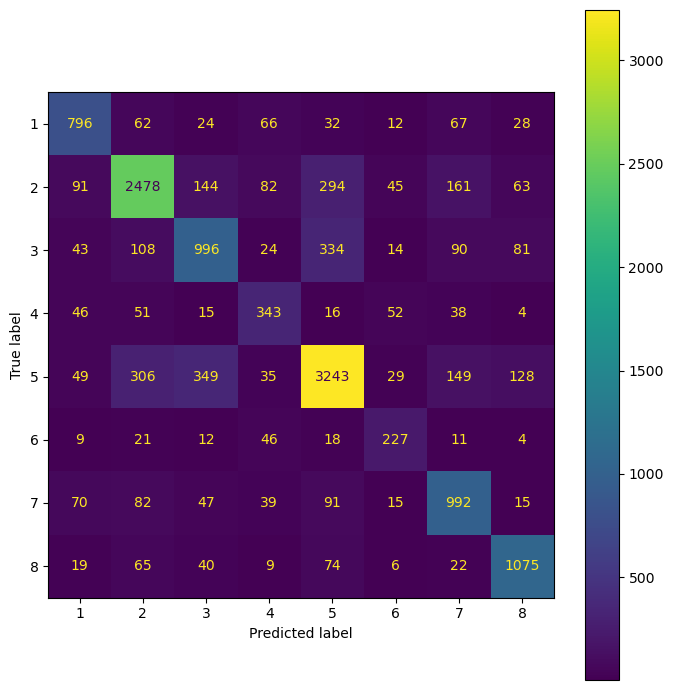

In [35]:
fig, ax = plt.subplots(figsize=(7, 7))
cm = ConfusionMatrixDisplay.from_estimator(
    best_model,
    X=rf_test,
    y=test_data[['target']],
    ax=ax
)
# ax.set_xticklabels(TARGETS, rotation=45)
# ax.set_yticklabels(TARGETS)
fig.tight_layout()
plt.show()

In [36]:
# print(classification_report(y_true=pred_df.y_true, y_pred=pred_df.y_pred, target_names=TARGETS))
print(classification_report(y_true=pred_df.y_true, y_pred=pred_df.y_pred))

              precision    recall  f1-score   support

           1       0.71      0.73      0.72      1087
           2       0.78      0.74      0.76      3358
           3       0.61      0.59      0.60      1690
           4       0.53      0.61      0.57       565
           5       0.79      0.76      0.77      4288
           6       0.57      0.65      0.61       348
           7       0.65      0.73      0.69      1351
           8       0.77      0.82      0.79      1310

    accuracy                           0.73     13997
   macro avg       0.68      0.70      0.69     13997
weighted avg       0.73      0.73      0.73     13997



## XGBoost

In [37]:
# from sklearn.utils.class_weight import compute_sample_weight

# sample_weights = compute_sample_weight(class_weight='balanced', y=train_data.user_id.values.ravel())

In [38]:
# from xgboost import XGBClassifier

# y_train = train_data.target.values.ravel() - 1
# y_test = test_data.target.values.ravel() - 1

# # weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_pred), y_pred)

# xgm = XGBClassifier(
#     n_estimators=300,
#     max_depth=None,
#     tree_method='hist',
#     objective='multi:softmax',
#     num_class=9
# ).fit(rf_train, y_train)

In [39]:
# preds = xgm.predict(rf_test)

# print(classification_report(y_true=y_test, y_pred=preds, target_names=TARGETS))

In [40]:
# import pickle

# # RF_RM.pkl = 0.8625 on test.
# # RF_RM_1.pkl = 0.77 on test.
# with open('../models/RF_RM_1.pkl', 'wb') as f:
#     f.write(pickle.dumps(model))

## TODO:


- Explain why location might not be a good feature to add (plot start and end on map and explain how model might just overfit to the raw coordinates)
- Merge `unknown` and `no_trip` into one category and validate against models trained on (a) separate labels (b) dropped labels
- Explore more of the abnormal `walking` trips